In [3]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,\
precision_recall_curve, roc_auc_score, confusion_matrix, make_scorer, roc_curve, auc
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectFromModel
import pickle
import gc
from datetime import datetime, date, time
from datetime import timedelta

pd.pandas.set_option('display.max_columns', None)
import warnings
warnings.simplefilter('ignore')

from sklearn.decomposition import PCA
import scipy.sparse
from sklearn.cluster import KMeans

In [4]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/opportunities_train.xlsx'
train_df = pd.read_excel(TRAIN_DATASET_PATH)
train_df.tail()

,id,priority,lead_source,reject_reason,description,product,phone,email,industry,web_form_of_consent,marketing_events,status,createdAt
5820,6533cb93-3623-437a-b648-386961cbb47b,2 [2],Сайт [web-site],Не спам [no_spam],есть описание,Advanced [advanced],да,да,Другое,да,нет,Квалифицирован [success],28.06.2022 10:56:26
5821,608bbe19-3eab-43aa-b94d-b5ad7a02b6a5,2 [2],Почта [email],Спам [spam],нет описания,нет,да,да,Другое,да,нет,Неквалифицирован [rejected],28.06.2022 10:00:28
5822,a249c458-18fc-4ade-9b4c-a01140d4f9c8,2 [2],Почта [email],Не спам [no_spam],нет описания,нет,да,да,Другое,да,нет,Неквалифицирован [rejected],28.06.2022 9:58:49
5823,5342ac59-6506-46fa-a153-d3e3a2ab8d09,2 [2],Почта [email],Не спам [no_spam],есть описание,Enterprise [enterprise],да,да,Другое,да,нет,Квалифицирован [success],28.06.2022 9:55:07
5824,a1df5704-f618-4d85-89c6-a6616385a647,3 [3],Мероприятие [event],Не спам [no_spam],нет описания,Advanced [advanced],да,да,Другое,да,нет,Квалифицирован [success],16.06.2022 19:22:56


In [5]:
TEST_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/opportunities_test.xlsx'
test_df = pd.read_excel(TEST_DATASET_PATH)
test_df.head(5)

,id,priority,lead_source,description,product,phone,email,industry,web_form_of_consent,marketing_events,status,createdAt
0,44f2bcea-d770-45даd64a0611b,3 [3],Сайт [web-site],нет описания,Advanced [advanced],да,да,Другое,да,да,Новые [new],21.02.2023 15:05:53
1,28d3667f-8f6e-41a6-8f1f-53f18a304827,2 [2],Сайт [web-site],есть описание,Enterprise [enterprise],да,да,Другое,нет,нет,В работе у Сейлов [sales_in_progress],21.02.2023 12:12:23
2,eca86dc4-7d20-43f6-b851-e44f7d244420,2 [2],Консультация [consultation],есть описание,Advanced [advanced],да,да,Другое,да,нет,В работе у Сейлов [sales_in_progress],21.02.2023 12:06:32
3,e85cb084-db84-451a-a409-abc6d367b261,2 [2],Консультация [consultation],есть описание,Advanced [advanced],да,да,Другое,да,нет,Квалифицирован [success],21.02.2023 10:58:54
4,3be820bd-9ca4-4a8c-9164-e085743f51eb,2 [2],Консультация [consultation],нет описания,Advanced [advanced],да,да,Другое,да,нет,Квалифицирован [success],21.02.2023 10:05:42


In [6]:
train_df.dtypes #смотрим типы данных

id                     object
priority               object
lead_source            object
reject_reason          object
description            object
product                object
phone                  object
email                  object
industry               object
web_form_of_consent    object
marketing_events       object
status                 object
createdAt              object
dtype: object

In [7]:
test_df.dtypes

id                     object
priority               object
lead_source            object
description            object
product                object
phone                  object
email                  object
industry               object
web_form_of_consent    object
marketing_events       object
status                 object
createdAt              object
dtype: object

In [8]:
test_df=pd.read_excel(TEST_DATASET_PATH)
test_df.tail()

,id,priority,lead_source,description,product,phone,email,industry,web_form_of_consent,marketing_events,status,createdAt
13179,18128c1a-b4e1-407e-895a-f28250628e24,2 [2],Почта [email],есть описание,ML Space [mlspace],да,да,Другое,да,да,Квалифицирован [success],29.06.2022 9:05:30
13180,f57f7342-813d-481c-88c0-145527b7f399,2 [2],Почта [email],есть описание,нет,да,да,Другое,да,нет,Квалифицирован [success],28.06.2022 15:53:45
13181,c6e5162e-c49f-4098-8c98-3b370281ec66,2 [2],Сайт [web-site],есть описание,Enterprise [enterprise],да,да,Другое,да,нет,Квалифицирован [success],28.06.2022 11:12:24
13182,6533cb93-3623-437a-b648-386961cbb47b,2 [2],Сайт [web-site],есть описание,Advanced [advanced],да,да,Другое,да,нет,Квалифицирован [success],28.06.2022 10:56:26
13183,5342ac59-6506-46fa-a153-d3e3a2ab8d09,2 [2],Почта [email],есть описание,Enterprise [enterprise],да,да,Другое,да,нет,Квалифицирован [success],28.06.2022 9:55:07


In [9]:
print('строк в трейне:', train_df.shape[0])
print('строк в тесте:', test_df.shape[0])

строк в трейне: 5825
строк в тесте: 13184


In [10]:
train_df.shape[1] - 1 == test_df.shape[1]

True

Целевым значением для нас будет значение "reject_reason" - то, является ли заявка спамом или нет. Вынесем этот столбец в отдельную переменную y, а в переменную X запишем все столбцы из таблицы кроме столбца target (reject_reason):

In [11]:
target = "reject_reason"

y = train_df[target]
X = train_df.drop(target, axis=1)

In [12]:
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5825 entries, 0 to 5824
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   5825 non-null   object
 1   priority             5825 non-null   object
 2   lead_source          5825 non-null   object
 3   description          5825 non-null   object
 4   product              5825 non-null   object
 5   phone                5825 non-null   object
 6   email                5825 non-null   object
 7   industry             5825 non-null   object
 8   web_form_of_consent  5825 non-null   object
 9   marketing_events     5825 non-null   object
 10  status               5825 non-null   object
 11  createdAt            5825 non-null   object
dtypes: object(12)
memory usage: 546.2+ KB


Чтобы использовать категориальные признаки в нашей модели, нужно перевести их в числовые. С колонками, в которых всего два варианта проще. У нас это 'phone', email, marketing_events, web_form_of_consent, description

In [13]:
phone_map = {
    'да': 1,
    'нет': 0,
}

X['phone'] = X['phone'].map(phone_map)

In [14]:
email_map = {
    'да': 1,
    'нет': 0,
}

X['email'] = X['email'].map(email_map)

In [15]:
marketing_events_map = {
    'да': 1,
    'нет': 0,
}

X['marketing_events'] = X['marketing_events'].map(marketing_events_map)

In [16]:
web_form_of_consent_map = {
    'да': 1,
    'нет': 0,
}

X['web_form_of_consent'] = X['web_form_of_consent'].map(web_form_of_consent_map)

In [17]:
description_map = {
    'есть описание': 1,
    'нет описания ': 0,
    'нет описания': 0,
}

X['description'] = X['description'].map(description_map)

Удалим столбец ID, т.к. он не несет никакой информационной нагрузки

In [18]:
X.drop(['id'], axis=1, inplace=True)

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5825 entries, 0 to 5824
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   priority             5825 non-null   object
 1   lead_source          5825 non-null   object
 2   description          5825 non-null   int64 
 3   product              5825 non-null   object
 4   phone                5825 non-null   int64 
 5   email                5825 non-null   int64 
 6   industry             5825 non-null   object
 7   web_form_of_consent  5825 non-null   int64 
 8   marketing_events     5825 non-null   int64 
 9   status               5825 non-null   object
 10  createdAt            5825 non-null   object
dtypes: int64(5), object(6)
memory usage: 500.7+ KB


In [20]:
X['product'].unique()

array(['ML Space [mlspace]', 'Advanced [advanced]',
       'Enterprise [enterprise]', 'нет'], dtype=object)

Есть столбцы, которые содержат более двух категорий, поэтому переводить их в числовые значения нельзя. Для них используем dummy-переменные. Вместо одной переменной 'product' заведём четыре переменных. В каждом из этих столбцов теперь будет стоять 1, если у соответствующего объекта переменная 'product' равна этому значению, и 0, если нет

In [21]:
X = pd.get_dummies (X, columns=['priority', 'lead_source', 'product', 'industry', 'status'])

X.head()

,description,phone,email,web_form_of_consent,marketing_events,createdAt,priority_1 [1],priority_2 [2],priority_3 [3],priority_4 [4],lead_source_Naumen [nsd],lead_source_SBBOL [sbbol],lead_source_Вебинар [webinar],lead_source_Звонок [call],lead_source_Исследование [research],lead_source_Клиент партнера [partner_client],lead_source_Консультация [consultation],lead_source_Личный контакт [networking],lead_source_Мероприятие [event],lead_source_Миграция данных [migration],lead_source_Партнер [partner],lead_source_Полка банка [bank],lead_source_Почта [email],lead_source_Сайт [web-site],lead_source_Чат-бот [chatbot],lead_source_нет,product_Advanced [advanced],product_Enterprise [enterprise],product_ML Space [mlspace],product_нет,industry_АПК [apk],industry_Другое,industry_Машиностроение [mechanical_engineering],industry_Строительные подрядчики [building],industry_Торговля [market],status_В работе у Сейлов [sales_in_progress],status_Квалифицирован [success],status_Неквалифицирован [rejected],status_Новые [new]
0,1,1,1,1,0,21.02.2023 15:37:50,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
1,1,1,0,1,0,21.02.2023 15:26:10,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
2,1,1,1,1,0,21.02.2023 14:12:51,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
3,1,1,1,0,0,21.02.2023 12:12:23,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,1,1,1,1,0,21.02.2023 12:06:32,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0


Поработаем с датой

In [22]:
date= ['createdAt']
X[date] = X[date].astype("datetime64")

X

,description,phone,email,web_form_of_consent,marketing_events,createdAt,priority_1 [1],priority_2 [2],priority_3 [3],priority_4 [4],lead_source_Naumen [nsd],lead_source_SBBOL [sbbol],lead_source_Вебинар [webinar],lead_source_Звонок [call],lead_source_Исследование [research],lead_source_Клиент партнера [partner_client],lead_source_Консультация [consultation],lead_source_Личный контакт [networking],lead_source_Мероприятие [event],lead_source_Миграция данных [migration],lead_source_Партнер [partner],lead_source_Полка банка [bank],lead_source_Почта [email],lead_source_Сайт [web-site],lead_source_Чат-бот [chatbot],lead_source_нет,product_Advanced [advanced],product_Enterprise [enterprise],product_ML Space [mlspace],product_нет,industry_АПК [apk],industry_Другое,industry_Машиностроение [mechanical_engineering],industry_Строительные подрядчики [building],industry_Торговля [market],status_В работе у Сейлов [sales_in_progress],status_Квалифицирован [success],status_Неквалифицирован [rejected],status_Новые [new]
0,1,1,1,1,0,2023-02-21 15:37:50,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
1,1,1,0,1,0,2023-02-21 15:26:10,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
2,1,1,1,1,0,2023-02-21 14:12:51,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
3,1,1,1,0,0,2023-02-21 12:12:23,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,1,1,1,1,0,2023-02-21 12:06:32,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5820,1,1,1,1,0,2022-06-28 10:56:26,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
5821,0,1,1,1,0,2022-06-28 10:00:28,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
5822,0,1,1,1,0,2022-06-28 09:58:49,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
5823,1,1,1,1,0,2022-06-28 09:55:07,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0


Мне нужно день недели и время

In [23]:
X['day'] = X['createdAt']. dt.weekday

X

,description,phone,email,web_form_of_consent,marketing_events,createdAt,priority_1 [1],priority_2 [2],priority_3 [3],priority_4 [4],lead_source_Naumen [nsd],lead_source_SBBOL [sbbol],lead_source_Вебинар [webinar],lead_source_Звонок [call],lead_source_Исследование [research],lead_source_Клиент партнера [partner_client],lead_source_Консультация [consultation],lead_source_Личный контакт [networking],lead_source_Мероприятие [event],lead_source_Миграция данных [migration],lead_source_Партнер [partner],lead_source_Полка банка [bank],lead_source_Почта [email],lead_source_Сайт [web-site],lead_source_Чат-бот [chatbot],lead_source_нет,product_Advanced [advanced],product_Enterprise [enterprise],product_ML Space [mlspace],product_нет,industry_АПК [apk],industry_Другое,industry_Машиностроение [mechanical_engineering],industry_Строительные подрядчики [building],industry_Торговля [market],status_В работе у Сейлов [sales_in_progress],status_Квалифицирован [success],status_Неквалифицирован [rejected],status_Новые [new],day
0,1,1,1,1,0,2023-02-21 15:37:50,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
1,1,1,0,1,0,2023-02-21 15:26:10,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
2,1,1,1,1,0,2023-02-21 14:12:51,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1
3,1,1,1,0,0,2023-02-21 12:12:23,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
4,1,1,1,1,0,2023-02-21 12:06:32,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5820,1,1,1,1,0,2022-06-28 10:56:26,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1
5821,0,1,1,1,0,2022-06-28 10:00:28,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1
5822,0,1,1,1,0,2022-06-28 09:58:49,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1
5823,1,1,1,1,0,2022-06-28 09:55:07,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1


In [24]:
X['time'] = X['createdAt']. dt.time

X

,description,phone,email,web_form_of_consent,marketing_events,createdAt,priority_1 [1],priority_2 [2],priority_3 [3],priority_4 [4],lead_source_Naumen [nsd],lead_source_SBBOL [sbbol],lead_source_Вебинар [webinar],lead_source_Звонок [call],lead_source_Исследование [research],lead_source_Клиент партнера [partner_client],lead_source_Консультация [consultation],lead_source_Личный контакт [networking],lead_source_Мероприятие [event],lead_source_Миграция данных [migration],lead_source_Партнер [partner],lead_source_Полка банка [bank],lead_source_Почта [email],lead_source_Сайт [web-site],lead_source_Чат-бот [chatbot],lead_source_нет,product_Advanced [advanced],product_Enterprise [enterprise],product_ML Space [mlspace],product_нет,industry_АПК [apk],industry_Другое,industry_Машиностроение [mechanical_engineering],industry_Строительные подрядчики [building],industry_Торговля [market],status_В работе у Сейлов [sales_in_progress],status_Квалифицирован [success],status_Неквалифицирован [rejected],status_Новые [new],day,time
0,1,1,1,1,0,2023-02-21 15:37:50,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,15:37:50
1,1,1,0,1,0,2023-02-21 15:26:10,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,15:26:10
2,1,1,1,1,0,2023-02-21 14:12:51,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,14:12:51
3,1,1,1,0,0,2023-02-21 12:12:23,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,12:12:23
4,1,1,1,1,0,2023-02-21 12:06:32,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,12:06:32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5820,1,1,1,1,0,2022-06-28 10:56:26,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,10:56:26
5821,0,1,1,1,0,2022-06-28 10:00:28,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,10:00:28
5822,0,1,1,1,0,2022-06-28 09:58:49,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,09:58:49
5823,1,1,1,1,0,2022-06-28 09:55:07,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,09:55:07


In [25]:
X['time'] = pd.to_datetime(X['time'], format='%H:%M:%S').dt.hour
X

,description,phone,email,web_form_of_consent,marketing_events,createdAt,priority_1 [1],priority_2 [2],priority_3 [3],priority_4 [4],lead_source_Naumen [nsd],lead_source_SBBOL [sbbol],lead_source_Вебинар [webinar],lead_source_Звонок [call],lead_source_Исследование [research],lead_source_Клиент партнера [partner_client],lead_source_Консультация [consultation],lead_source_Личный контакт [networking],lead_source_Мероприятие [event],lead_source_Миграция данных [migration],lead_source_Партнер [partner],lead_source_Полка банка [bank],lead_source_Почта [email],lead_source_Сайт [web-site],lead_source_Чат-бот [chatbot],lead_source_нет,product_Advanced [advanced],product_Enterprise [enterprise],product_ML Space [mlspace],product_нет,industry_АПК [apk],industry_Другое,industry_Машиностроение [mechanical_engineering],industry_Строительные подрядчики [building],industry_Торговля [market],status_В работе у Сейлов [sales_in_progress],status_Квалифицирован [success],status_Неквалифицирован [rejected],status_Новые [new],day,time
0,1,1,1,1,0,2023-02-21 15:37:50,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,15
1,1,1,0,1,0,2023-02-21 15:26:10,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,15
2,1,1,1,1,0,2023-02-21 14:12:51,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,14
3,1,1,1,0,0,2023-02-21 12:12:23,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,12
4,1,1,1,1,0,2023-02-21 12:06:32,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5820,1,1,1,1,0,2022-06-28 10:56:26,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,10
5821,0,1,1,1,0,2022-06-28 10:00:28,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,10
5822,0,1,1,1,0,2022-06-28 09:58:49,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,9
5823,1,1,1,1,0,2022-06-28 09:55:07,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,9


In [26]:
def time_to_cat_pandas(X):
  bins = [0, 4, 8, 12, 16, 20, X['time'].max()]
  X['time_cat'] = pd.cut(X['time'], bins=bins)
  
  return X

In [27]:
time_to_cat_pandas(X)
X

,description,phone,email,web_form_of_consent,marketing_events,createdAt,priority_1 [1],priority_2 [2],priority_3 [3],priority_4 [4],lead_source_Naumen [nsd],lead_source_SBBOL [sbbol],lead_source_Вебинар [webinar],lead_source_Звонок [call],lead_source_Исследование [research],lead_source_Клиент партнера [partner_client],lead_source_Консультация [consultation],lead_source_Личный контакт [networking],lead_source_Мероприятие [event],lead_source_Миграция данных [migration],lead_source_Партнер [partner],lead_source_Полка банка [bank],lead_source_Почта [email],lead_source_Сайт [web-site],lead_source_Чат-бот [chatbot],lead_source_нет,product_Advanced [advanced],product_Enterprise [enterprise],product_ML Space [mlspace],product_нет,industry_АПК [apk],industry_Другое,industry_Машиностроение [mechanical_engineering],industry_Строительные подрядчики [building],industry_Торговля [market],status_В работе у Сейлов [sales_in_progress],status_Квалифицирован [success],status_Неквалифицирован [rejected],status_Новые [new],day,time,time_cat
0,1,1,1,1,0,2023-02-21 15:37:50,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,15,"(12, 16]"
1,1,1,0,1,0,2023-02-21 15:26:10,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,15,"(12, 16]"
2,1,1,1,1,0,2023-02-21 14:12:51,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,14,"(12, 16]"
3,1,1,1,0,0,2023-02-21 12:12:23,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,12,"(8, 12]"
4,1,1,1,1,0,2023-02-21 12:06:32,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,12,"(8, 12]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5820,1,1,1,1,0,2022-06-28 10:56:26,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,10,"(8, 12]"
5821,0,1,1,1,0,2022-06-28 10:00:28,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,10,"(8, 12]"
5822,0,1,1,1,0,2022-06-28 09:58:49,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,9,"(8, 12]"
5823,1,1,1,1,0,2022-06-28 09:55:07,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,9,"(8, 12]"


In [28]:
X.time_cat = pd.Categorical(X.time_cat)
X['time_cat_code'] =X.time_cat.cat.codes



In [29]:
X

,description,phone,email,web_form_of_consent,marketing_events,createdAt,priority_1 [1],priority_2 [2],priority_3 [3],priority_4 [4],lead_source_Naumen [nsd],lead_source_SBBOL [sbbol],lead_source_Вебинар [webinar],lead_source_Звонок [call],lead_source_Исследование [research],lead_source_Клиент партнера [partner_client],lead_source_Консультация [consultation],lead_source_Личный контакт [networking],lead_source_Мероприятие [event],lead_source_Миграция данных [migration],lead_source_Партнер [partner],lead_source_Полка банка [bank],lead_source_Почта [email],lead_source_Сайт [web-site],lead_source_Чат-бот [chatbot],lead_source_нет,product_Advanced [advanced],product_Enterprise [enterprise],product_ML Space [mlspace],product_нет,industry_АПК [apk],industry_Другое,industry_Машиностроение [mechanical_engineering],industry_Строительные подрядчики [building],industry_Торговля [market],status_В работе у Сейлов [sales_in_progress],status_Квалифицирован [success],status_Неквалифицирован [rejected],status_Новые [new],day,time,time_cat,time_cat_code
0,1,1,1,1,0,2023-02-21 15:37:50,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,15,"(12, 16]",3
1,1,1,0,1,0,2023-02-21 15:26:10,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,15,"(12, 16]",3
2,1,1,1,1,0,2023-02-21 14:12:51,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,14,"(12, 16]",3
3,1,1,1,0,0,2023-02-21 12:12:23,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,12,"(8, 12]",2
4,1,1,1,1,0,2023-02-21 12:06:32,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,12,"(8, 12]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5820,1,1,1,1,0,2022-06-28 10:56:26,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,10,"(8, 12]",2
5821,0,1,1,1,0,2022-06-28 10:00:28,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,10,"(8, 12]",2
5822,0,1,1,1,0,2022-06-28 09:58:49,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,9,"(8, 12]",2
5823,1,1,1,1,0,2022-06-28 09:55:07,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,9,"(8, 12]",2


In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5825 entries, 0 to 5824
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype         
---  ------                                            --------------  -----         
 0   description                                       5825 non-null   int64         
 1   phone                                             5825 non-null   int64         
 2   email                                             5825 non-null   int64         
 3   web_form_of_consent                               5825 non-null   int64         
 4   marketing_events                                  5825 non-null   int64         
 5   createdAt                                         5825 non-null   datetime64[ns]
 6   priority_1 [1]                                    5825 non-null   uint8         
 7   priority_2 [2]                                    5825 non-null   uint8         
 8   priority_3 [3]              

Удалим createdAt

In [31]:
X.drop(['createdAt'], axis=1, inplace=True)
X.drop(['time_cat'], axis=1, inplace=True)
X.drop(['time'], axis=1, inplace=True)

X

,description,phone,email,web_form_of_consent,marketing_events,priority_1 [1],priority_2 [2],priority_3 [3],priority_4 [4],lead_source_Naumen [nsd],lead_source_SBBOL [sbbol],lead_source_Вебинар [webinar],lead_source_Звонок [call],lead_source_Исследование [research],lead_source_Клиент партнера [partner_client],lead_source_Консультация [consultation],lead_source_Личный контакт [networking],lead_source_Мероприятие [event],lead_source_Миграция данных [migration],lead_source_Партнер [partner],lead_source_Полка банка [bank],lead_source_Почта [email],lead_source_Сайт [web-site],lead_source_Чат-бот [chatbot],lead_source_нет,product_Advanced [advanced],product_Enterprise [enterprise],product_ML Space [mlspace],product_нет,industry_АПК [apk],industry_Другое,industry_Машиностроение [mechanical_engineering],industry_Строительные подрядчики [building],industry_Торговля [market],status_В работе у Сейлов [sales_in_progress],status_Квалифицирован [success],status_Неквалифицирован [rejected],status_Новые [new],day,time_cat_code
0,1,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,3
1,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,3
2,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,3
3,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,2
4,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5820,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,2
5821,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,2
5822,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,2
5823,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,2


Разобъем на тренировочну и валидацмонную

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

##**Начнем с простой модели LogisticRegression**

In [33]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver="liblinear")

lr.fit(X_train, y_train)

y_pred = lr.predict(X_valid)

In [34]:
from sklearn.metrics import accuracy_score

accuracy_score(y_valid, y_pred)

0.7789979409746054

Теперь предсказание на тренировочном датасете и посчитаю точность на нём:

In [68]:
y_pred_train = lr.predict(X_train)

accuracy_score(y_train, y_pred_train)

0.7886904761904762

In [36]:
y_pred_proba = lr.predict_proba(X_valid)

y_pred_proba[:10]

array([[0.96659347, 0.03340653],
       [0.05990893, 0.94009107],
       [0.95624232, 0.04375768],
       [0.99799447, 0.00200553],
       [0.06915063, 0.93084937],
       [0.99566825, 0.00433175],
       [0.2499684 , 0.7500316 ],
       [0.31364821, 0.68635179],
       [0.55498925, 0.44501075],
       [0.99685963, 0.00314037]])

##**Попробую метод Support Vector Machine (SVM)**



In [37]:
from sklearn.svm import SVC

Нормализуем признаки

In [38]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

X_valid = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)

Создам модель и обучу её на тренировочных данных, а затем проверю её качество на валидационной выборке:

In [39]:
clf = SVC(gamma="auto")

clf.fit(X_train, y_train)

y_pred = clf.predict(X_valid)
y_pred_train = clf.predict(X_train)

In [40]:
accuracy_score(y_valid, y_pred)

0.7824296499656829

In [41]:
accuracy_score(y_train, y_pred_train)

0.7811355311355311

Попробую улучшить. Штрафы

In [42]:
c_values = np.logspace(-2, 5, 36)

accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate(c_values):
    clf = SVC(C=value, gamma="auto")
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_valid)
    y_pred_train = clf.predict(X_train)
        
    acc_valid = accuracy_score(y_valid, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    if i % 5 == 0:
        print('C = {}'.format(value))
        print('\tacc_valid = {}'.format(acc_valid))
        print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)

C = 0.01
	acc_valid = 0.6678105696636926
	acc_train = 0.6781135531135531

C = 0.1
	acc_valid = 0.7687028140013726
	acc_train = 0.7612179487179487

C = 1.0
	acc_valid = 0.7824296499656829
	acc_train = 0.7811355311355311

C = 10.0
	acc_valid = 0.7858613589567605
	acc_train = 0.7882326007326007

C = 100.0
	acc_valid = 0.7947838023335622
	acc_train = 0.81753663003663

C = 1000.0
	acc_valid = 0.824296499656829
	acc_train = 0.8440934065934066

C = 10000.0
	acc_valid = 0.820178448867536
	acc_train = 0.8486721611721612

C = 100000.0
	acc_valid = 0.8181194234728895
	acc_train = 0.8546245421245421



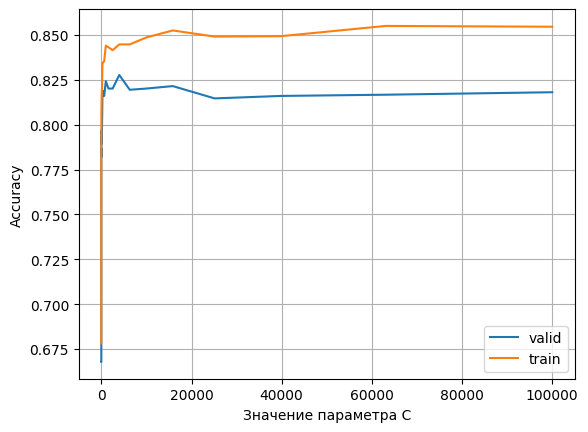

In [43]:
plt.plot(c_values, accuracy_on_valid, label="valid")
plt.plot(c_values, accuracy_on_train, label="train")

plt.xlabel('Значение параметра C')
plt.ylabel('Accuracy')

plt.legend()
plt.grid()

plt.show()

точность на валидационных данных до определённого момента растёт, но затем начинает падать. Пик точности попадает приблизительно на значение  C=4500 . Дальше мы видим спад точности на валидационных данных, однако, точность на тренировочных данных продолжает расти. Это означает, что модель начинает переобучаться.

Можно заметить, что точность на валидационных данных при  C=4500  уже выше, чем при использовании логистической регрессии, а также выше, чем при использовании SVM без настройки параметров.

Попробую следующую модель 
##**KNN (K Nearest Neighbours)** 
или K ближайших соседей. Представлю каждый объект из данных в виде точки в пространстве признаков и предположу, что объекты одного класса расположены в пространстве близко друг к другу. Раз так, то можно классифицировать новый объект исходя из того, какие объекты находятся в пространстве рядом с ним.

если берем расстояние между объектами, то нужно отмасштабировать признаки так, чтобы они вносили в это расстояние соизмеримый вклад. Использую RobustScaler. При таком подходе масштабирования признаков минимизируется влияние выбросов в данных т.к.при масштабировании используется медиана и интерквартильный размах.

In [44]:
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier

In [45]:
k_values = np.arange(1, 11)

accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate(k_values):
    clf = KNeighborsClassifier(n_neighbors=value)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_valid)
    y_pred_train = clf.predict(X_train)
        
    acc_valid = accuracy_score(y_valid, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    if i % 2 == 0:
        print('K = {}'.format(value))
        print('\tacc_valid = {}'.format(acc_valid))
        print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)

K = 1
	acc_valid = 0.8160603980782429
	acc_train = 0.877518315018315

K = 3
	acc_valid = 0.8297872340425532
	acc_train = 0.8786630036630036

K = 5
	acc_valid = 0.8318462594371997
	acc_train = 0.8786630036630036

K = 7
	acc_valid = 0.8345916266300618
	acc_train = 0.8727106227106227

K = 9
	acc_valid = 0.8442004118050789
	acc_train = 0.8653846153846154



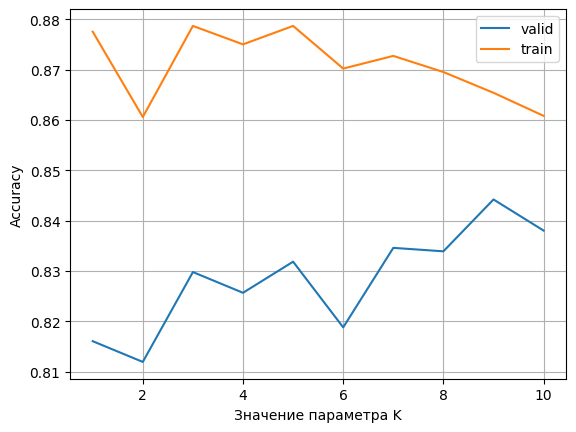

In [46]:
plt.plot(k_values, accuracy_on_valid, label="valid")
plt.plot(k_values, accuracy_on_train, label="train")

plt.xlabel('Значение параметра K')
plt.ylabel('Accuracy')

plt.legend()
plt.grid()

plt.show()

Оптимальным значением является к=7. Построю с этим значением



In [47]:
clf = KNeighborsClassifier(n_neighbors=7)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_valid)

accuracy_score(y_valid, y_pred)

0.8345916266300618

**Текст, выделенный полужирным шрифтом**##**Метрики качества**

Для KNN буду использовать confusion matrix, т.е. матрицу ошибок.

In [48]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid, y_pred)

print(cm)

[[861 112]
 [129 355]]


True Negative (TN) - правильно классифицировали объект как объект класса 0 (левое верхнее значение)

False Positive (FP) - классифицировала объект как объект класса 1, хотя, он на самом деле имеет класс 0 (правое верхнее)

False Negative (FN) - классифицировала объект как объект класса 0, а на самом деле он имеет класс 1 (левое нижнее)

True Positive (TP) - правильно классифицировали объект как объект класса 1 (правое нижнее)

In [49]:

# Accuracy
from sklearn.metrics import accuracy_score
a_s = accuracy_score(y_valid, y_pred)
# Recall
from sklearn.metrics import recall_score
r_s = recall_score(y_valid, y_pred, average=None)
# Precision
from sklearn.metrics import precision_score
p_s = precision_score(y_valid, y_pred, average=None)
# f1_score
from sklearn.metrics import f1_score
f1 = f1_score(y_valid, y_pred, average=None)
print(a_s)
print(r_s)
print(p_s)
print(f1)



0.8345916266300618
[0.88489209 0.73347107]
[0.86969697 0.76017131]
[0.87722873 0.74658254]


##**Деревья решений**

In [50]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

In [51]:
max_depth_values = np.arange(2, 20)

accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate(max_depth_values):
    clf = DecisionTreeClassifier(max_depth=value)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_valid)
    y_pred_train = clf.predict(X_train)
        
    acc_valid = accuracy_score(y_valid, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    if i % 4 == 2:
        print('K = {}'.format(value))
        print('\tacc_valid = {}'.format(acc_valid))
        print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)

K = 4
	acc_valid = 0.7872340425531915
	acc_train = 0.7825091575091575

K = 8
	acc_valid = 0.8428277282086479
	acc_train = 0.8521062271062271

K = 12
	acc_valid = 0.8544955387783116
	acc_train = 0.8843864468864469

K = 16
	acc_valid = 0.8284145504461222
	acc_train = 0.9022435897435898



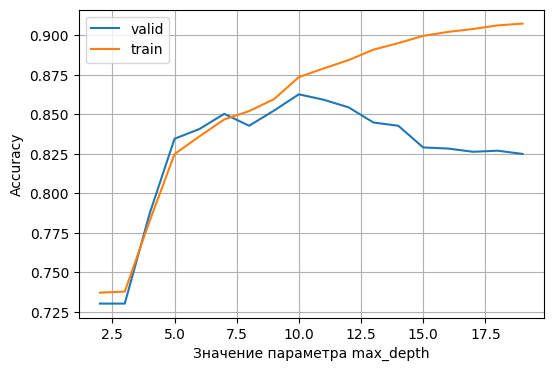

In [52]:
plt.rcParams['figure.figsize'] = 6, 4

plt.plot(max_depth_values, accuracy_on_valid, label="valid")
plt.plot(max_depth_values, accuracy_on_train, label="train")

plt.xlabel('Значение параметра max_depth')
plt.ylabel('Accuracy')

plt.legend()
plt.grid()

plt.show()

при достаточно больших значениях параметра `max_depth` точность на тренировочных данных почти достигает 1. На валидационных же данных точность достигает своего пика приблизительно на значении `max_depth = 10`, а затем начинает падать.

In [53]:
clf = DecisionTreeClassifier(max_depth=10)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_valid)

accuracy_score(y_valid, y_pred)

0.8627316403568978

##**RandomForest**

In [54]:
from sklearn.ensemble import RandomForestClassifier

n_estimators - число деревьев в ансамбле

max_features - максимальное число признаков, которое может быть использовано при построении каждого дерева

max_depth - максимальная глубина 

Для того, чтобы выбрать подходящий набор параметров, использую Grid search

In [55]:
from sklearn.model_selection import GridSearchCV

In [56]:
parameters = {
    'n_estimators': [150, 200, 250],
    'max_features': np.arange(5, 9),
    'max_depth': np.arange(5, 10),
}

clf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=parameters,
    scoring='accuracy',
    cv=5,
    return_train_score=True
)

In [57]:
clf.fit(X_train, y_train) #кроссвалидация

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([5, 6, 7, 8, 9]),
                         'max_features': array([5, 6, 7, 8]),
                         'n_estimators': [150, 200, 250]},
             return_train_score=True, scoring='accuracy')

In [58]:
cv_results = pd.DataFrame(clf.cv_results_)

cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [59]:
param_columns = [
    column
    for column in cv_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score', 'mean_train_score']

cv_results = (cv_results[param_columns + score_columns].sort_values(by=score_columns, ascending=False))

cv_results.head(10)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,mean_train_score
58,9,8,200,0.847988,0.868876
56,9,7,250,0.846157,0.867502
57,9,8,150,0.846156,0.869219
59,9,8,250,0.845927,0.870021
54,9,7,150,0.845926,0.867331
47,8,8,250,0.845012,0.862237
46,8,8,200,0.845012,0.861550
51,9,6,150,0.844554,0.868418
44,8,7,250,0.843868,0.861264
40,8,6,200,0.843867,0.860463


In [60]:
clf.best_params_

{'max_depth': 9, 'max_features': 8, 'n_estimators': 200}

In [61]:
clf = RandomForestClassifier(max_depth=9, max_features=7, n_estimators=200)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_valid)

accuracy_score(y_valid, y_pred)

0.8551818805765271

Лучшая метрика у деревьев решений

##**Обучение и оценка модели**

In [62]:
final_model = DecisionTreeClassifier(max_depth=10)

final_model.fit(X_train, y_train)



DecisionTreeClassifier(max_depth=10)

In [63]:
y_train_preds = final_model.predict(X_train)

In [64]:
final_model.feature_importances_

array([0.02180688, 0.00561083, 0.06212782, 0.01014397, 0.0110517 ,
       0.00180816, 0.00308224, 0.        , 0.        , 0.00065709,
       0.00095011, 0.0056136 , 0.        , 0.00100431, 0.        ,
       0.03467064, 0.        , 0.00569647, 0.00116471, 0.        ,
       0.00104667, 0.17569161, 0.00937497, 0.        , 0.        ,
       0.0023655 , 0.01050255, 0.00489864, 0.00389713, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.3736578 , 0.0036857 , 0.10937909, 0.14011178])

In [65]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [70]:
feature_importances.head(6)

,feature_name,importance
36,status_Неквалифицирован [rejected],0.373658
21,lead_source_Почта [email],0.175692
39,time_cat_code,0.140112
38,day,0.109379
2,email,0.062128
15,lead_source_Консультация [consultation],0.034671


In [67]:
feature_importances.tail(3)

,feature_name,importance
14,lead_source_Клиент партнера [partner_client],0.0
12,lead_source_Звонок [call],0.0
23,lead_source_Чат-бот [chatbot],0.0
